## Deep Learning Gradauate School Admission Regression

This notebook was built for the Graduate School Admissions Regression Challenge Project for the Codecademy course: Build Deep Learning Models with TensorFlow.

We were give a dataset with multiple variables to predict the chance a student will get into graduate school. The dataset can be found here:
https://www.kaggle.com/mohansacharya/graduate-admissions?select=Admission_Predict_Ver1.1.csv

### Importing necessary modules

In [49]:
import tensorflow as tf
import pandas as pd

### Reading in data and getting a first look

In [50]:
#reading in data
adm_data = pd.read_csv('admissions_data.csv')

In [51]:
#looking at the first 5 rows
print(adm_data.head())
# print(adm_data.columns)
# print(adm_data.describe())

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  


(Taken from the codecademy website)  
This dataset has nine different columns:  

Serial No.: Index of each row (1-500)  
GRE Score: GRE test score (out of 340)  
TOEFL Score: TOEFL test score (out of 120)  
University Rating: Evaluated university rating (out of 5)  
SOP: Statement of Purpose Strength (out of 5)  
LOR: Letter of Recommendation Strength (out of 5)  
CGPA: Undergraduate GPA (out of 10)  
Research: Has research experience (either 0 or 1)  
Chance of Admit: Applicant’s chance of being admitted (ranging from 0 to 1)  

### Checking for NA values

In [52]:
#checking for NA values
adm_data.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

### Renaming columns as appropriate

In [53]:
#converting columns to lowercase and renaming
adm_data.columns = map(str.lower, adm_data.columns)
#renaming columns to make accessing them easier
print(adm_data.columns)
#there is a space at the end of 'chance of admit '
adm_data = adm_data.rename(columns={'serial no.': 'serial_no', 'gre score': 'gre_score', 'toefl score': 'toefl_score', 'university rating': 'univ_rating', 'chance of admit ': 'adm_percent' })
print(adm_data.columns)

Index(['serial no.', 'gre score', 'toefl score', 'university rating', 'sop',
       'lor ', 'cgpa', 'research', 'chance of admit '],
      dtype='object')
Index(['serial_no', 'gre_score', 'toefl_score', 'univ_rating', 'sop', 'lor ',
       'cgpa', 'research', 'adm_percent'],
      dtype='object')


### Quick data exploration 

Looking at the min and max values of the response(dependent) variable.

In [54]:
print(adm_data.adm_percent.max())
print(adm_data.adm_percent.min())

0.97
0.34


The TOEFL test is given to non-native English speakers applying to universities. Test Of English as a Foreign Language. It is interesting that this is not metioned in the description for the dataset as this is a particular group of students applying to universities.

In [55]:
print(adm_data.toefl_score.unique())

[118 107 104 110 103 115 109 101 102 108 106 111 112 105 114 116 119 120
  98  93  99  97 117 113 100  95  96  94  92]


Every student has a TOEFL test value, therefore none of these applicants are native English speakers.

Want to look at the corelation between all the variables to see if there are any independent variables that are highly correlated with one another, we usually remove these variable, also called multicollinear. Also want to see how these variables are correlated with the dependent variable, 'adm_percent'.

Text(0.5, 1.0, 'Pearson Correlation Coefficients')

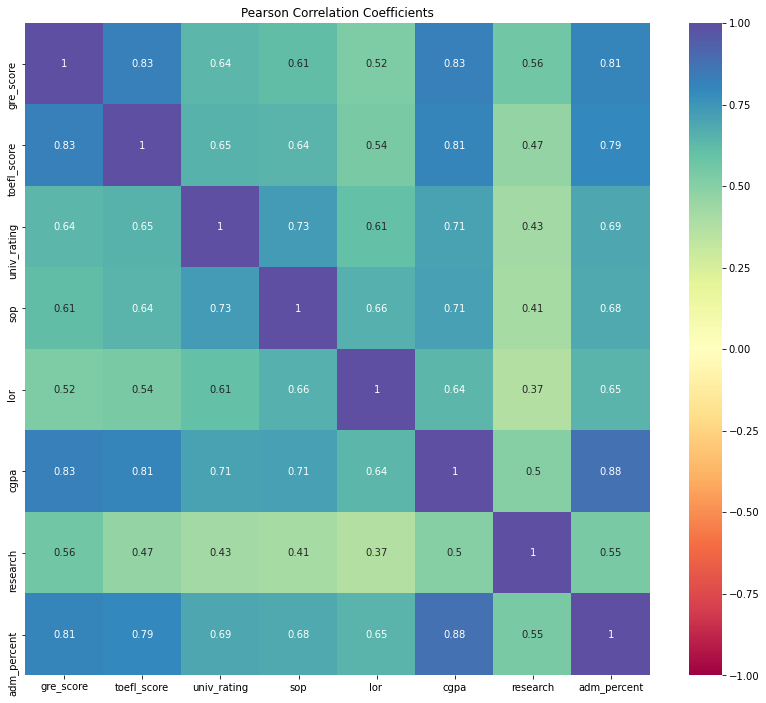

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

#removing serial_no. variable
correlation = adm_data.iloc[:, 1:]

#creating correaltion matrix as heatmap for easy detection of correaltion
plt.figure(figsize=(14, 12))
ax = sns.heatmap(correlation.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap="Spectral")
ax.set_title('Pearson Correlation Coefficients')


None of our variables are multicollinear so we can use all of them as predictors. It is also seen that all of the independent variables are mig-highly correlated with our dependent variable. Looks like we are on the right track!

Looking at the pair plot between all variables to look at the relationships.

In [ ]:
sns.pairplot(correlation)

They all look to have postive linear relationships with one another, except 'research' as this is more categorical.

### Creating feature and label datasets

We are trying to predict the probability that someone will get into graduate school, therefore, we are trying to predict the 'adm_percent' or percent change of admission.

Every column is numerical so no reason to perform one-hot encoding.
Each column except 'serial_no' looks to be significant to the data analysis, I am not going to include this column in my analysis.

In [ ]:
#Splitting the data into feature and label sets
labels = adm_data.iloc[:,-1]
#print(labels)
features = adm_data.iloc[:, 1:-1]
print(features.head())

### Splitting data into train and test datasets

In [ ]:
##Splitting data into train and test datasets
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(features, labels, test_size = 0.20, random_state = 42)
print(len(test))
print(len(train))

### Data Standardization

As seen in the descriptions earlier, the data is on multiple scales. The best way to deal with this so as to work well with any model is to normalize the data.

In [ ]:
#Standardizng all numerical columns in the dataset. In this case, that is all columns of data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
num_features = features.select_dtypes(include=['float64', 'int64'])
num_cols = num_features.columns
ct = ColumnTransformer([('standardize', StandardScaler(), num_cols)], remainder = 'passthrough')
train_scaled = ct.fit_transform(train)
test_scaled = ct.transform(test)

### Model Creation

In [ ]:
#Using tf Sequential to start a model
from tensorflow.keras.models import Sequential
reg_model = Sequential()

### Input layer

This layer has the same number of nodes as features in your data, an additional node can be added as a bias term

In [ ]:
#Creating an input layer with the number of features in our dataset
#Some neural networks add an additional node here for a bias term
from tensorflow.keras import layers
num_features = train_scaled.shape[1]
input = layers.InputLayer(input_shape=(num_features,))
reg_model.add(input)

### Hidden Layers

In [ ]:
#adding hidden layer with 64 neurons
reg_model.add(layers.Dense(64, activation='relu'))

### Output layer

Regression models have one output node as they are continous variables and not categorical

In [ ]:
#adding output layer
reg_model.add(layers.Dense(1))

### Backpropagation and model compilation

Compiling the model with loss metrics and the SGD optimizer.

In [ ]:
#importing optimizer and compiling model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.01)

reg_model.compile(loss='mae',  metrics=['mean_squared_error'], optimizer=opt)


### Model fit and evaluation with early stopping

Using early stopping to find number of epochs. Too many will lead to overfitting and too few will lead to underfitting. 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
#Using early stopping to find number of epochs to train. Too many will lead to overfitting and too few will lead to 
#underfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = reg_model.fit(train_scaled, train_labels, epochs=500, batch_size=1, verbose=0, validation_split = 0.2, callbacks = [es])


Plotting figures that show the MSE and MAE loss metrics and show where the model employed the early stopping.

In [ ]:
#creating figure area for 2 plots side-by-side
fig, axs = plt.subplots(1,2, figsize=(15, 8))
plt.suptitle('Loss functions and Number of Epochs with Early-Stopping')
(ax1, ax2) = axs

#first plot MAE vs epochs
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend(loc="upper right")
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('MAE')

#second plot MSE vs epochs
ax2.plot(history.history['mean_squared_error'], label='train')
ax2.plot(history.history['val_mean_squared_error'], label='validation')
ax2.legend(loc="upper right")
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('MSE')

### Model Evaluation with R-Squared, MSE, and MAE

In [ ]:
from sklearn.metrics import r2_score

#model evaluation with mae, and mse
res_mae, res_mse = reg_model.evaluate(test_scaled, test_labels, verbose=0)

res_mse = round(res_mse, 5)
res_mae = round(res_mae, 4)
print(res_mse, res_mae)

#getting predicted values
predictions = reg_model.predict(test_scaled)
#calculating R^2 using the predicted values and actual labels.
r2 = round(r2_score(test_labels, predictions) * 100, 2)
print(r2)

In [ ]:
print('MAE is ' + f'{res_mse:.{4}f}' + ' which means if we were to randomly look at a datapoint, our prediction would be ' + f'{res_mse:.{4}f}' ' off from the    actual value.')
print('Great! The model explains ' + f'{r2:.{0}f}' + '% of the variance in the chance of admissions percentage.')

### MAE Baseline

The dummy regressor is used to predict a simple baseline for the test data. In this case, I have used median, so the dummy regressor uses the train data to predict the median of the test data. This serves as a baseline in which to compare the mae found using our regression model. 

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(train_scaled, train_labels)
y_pred = dummy_regr.predict(test_scaled)
mae_baseline = round(mean_absolute_error(test_labels, predictions), 5)
print(mae_baseline)

In [ ]:
print('Our model gave an mae of  ' + f'{res_mae:.{4}f}' + '  and our baseline is  ' + f'{mae_baseline:.{4}f}' + ' , so we met the baseline parameter.')

### Conclusions

The best model found could only make the baseline MAE value, but explained a lot of the variance in our model.

I will continue to play with different hyperpaprameters during this course to understand how I can get better predictions in the future.